In [1]:
import warnings
import calendar

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from business_models import greenplum
from business_models.greenplum import GreenplumManager
from business_models import hahn

https://wiki.yandex-team.ru/users/ghostrider/cargo-x-efficiency/.edit?force-data-ui=true

In [2]:
regions = {
    'br': ['br_moscow', 'br_saintpetersburg', 'br_krasnodar', 'br_novosibirsk'],
    'cities': ['Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk']
    }

# рост WoW деманда и саплая

In [35]:
dem_sup_wow_sql = '''
    with supply as (
        select case agglomeration_geo_node_id
                   when 'br_moscow' then 'Moscow'
                   when 'br_saintpetersburg' then 'Saint-Petersburg'
                   when 'br_krasnodar' then 'Krasnodar'
                   when 'br_novosibirsk' then 'Novosibirsk'
                       end city_name_en
               , date_trunc('week', msk_valid_from_dttm) week_dt,
               count(distinct park_taximeter_id ||'_'||executor_profile_id) supply
        from taxi_cdm_supply.fct_supply_state_hist s
        where enabled_tariff_class_code_list && '{"cargo", "cargocorp","cargo_long", "cargo_express"}'
          and agglomeration_geo_node_id in ('br_moscow', 'br_saintpetersburg', 'br_krasnodar', 'br_novosibirsk')
          and msk_valid_from_dttm::date between '2023-04-24' and '2023-07-30'
          and executor_status_code in ('free', 'waiting', 'driving', 'transporting')
        group by 1, 2),
    demand as (
        select source_city_name_en city_name_en, date_trunc('week', utc_created_dttm + interval '3 hour') week_dt,
               count(distinct initiator_phone_pd_id) demand
        from delivery_cdm_delivery.fct_delivery d
        where 1=1
          and d.utc_order_created_dttm::date between '2023-04-24' and '2023-07-30'
          and claim_created_tariff_class_code_list && '{"cargo", "cargocorp","cargo_long", "cargo_express"}'
          and source_country_name_en = 'Russia'
          and source_city_name_en in ('Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk')
        group by 1, 2),
    data as (
        select s.week_dt, s.city_name_en, supply, demand,
               row_number() over (partition by s.city_name_en order by s.week_dt) rn
        from supply s
        join demand d on d.week_dt = s.week_dt and d.city_name_en = s.city_name_en)
    select d1.week_dt::date,
           d1.city_name_en,
           d1.supply, d1.demand, d2.supply supply_last_week, d2.demand demand_last_week
    from data d1
    join data d2 on d2.rn = d1.rn -1 and d2.city_name_en = d1.city_name_en
'''

In [36]:
ds_wow = greenplum(dem_sup_wow_sql)

In [37]:
ds_wow['supply_wow'] = (ds_wow['supply'] - ds_wow['supply_last_week']) / ds_wow['supply_last_week']
ds_wow['demand_wow'] = (ds_wow['demand'] - ds_wow['demand_last_week']) / ds_wow['demand_last_week']

In [44]:
ds_wow['week_dt'] = ds_wow['week_dt'].astype(str)

In [45]:
ds_wow#.sort_values(by='week_dt')

,week_dt,city_name_en,supply,demand,supply_last_week,demand_last_week,supply_wow,demand_wow
0,2023-05-01,Novosibirsk,785,5926,829,6080,-0.053076,-0.025329
1,2023-05-08,Novosibirsk,720,5554,785,5926,-0.082803,-0.062774
2,2023-05-15,Novosibirsk,761,6214,720,5554,0.056944,0.118833
3,2023-05-22,Novosibirsk,776,6426,761,6214,0.019711,0.034117
4,2023-05-29,Novosibirsk,738,6377,776,6426,-0.048969,-0.007625
5,2023-06-05,Novosibirsk,690,6138,738,6377,-0.065041,-0.037478
6,2023-06-12,Novosibirsk,750,6148,690,6138,0.086957,0.001629
7,2023-06-19,Novosibirsk,769,6376,750,6148,0.025333,0.037085
8,2023-06-26,Novosibirsk,790,6595,769,6376,0.027308,0.034348
9,2023-07-03,Novosibirsk,738,6530,790,6595,-0.065823,-0.009856


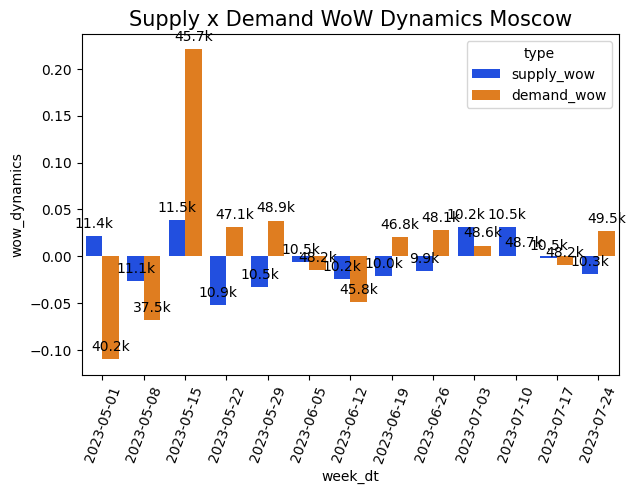

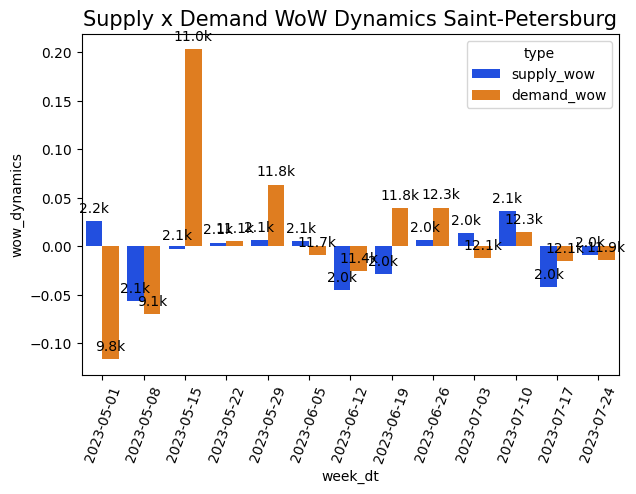

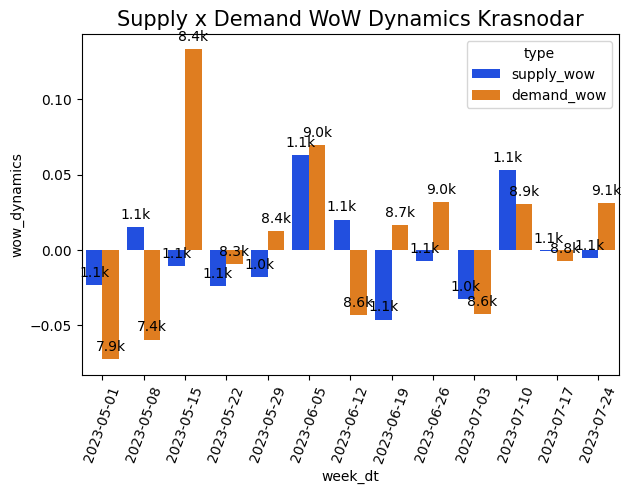

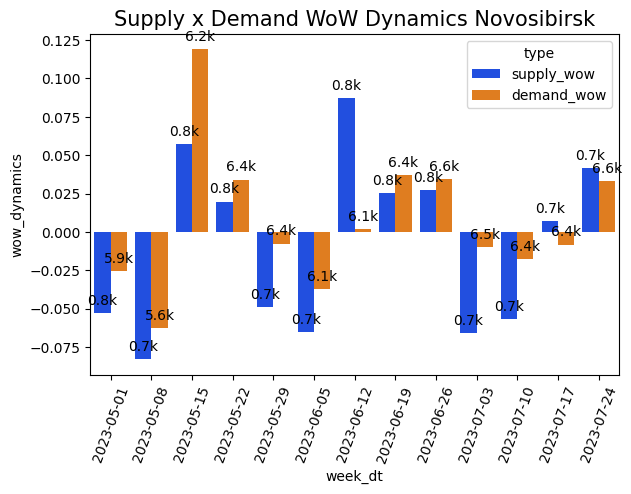

In [93]:
for node in regions['cities']:
    df_i = ds_wow[ds_wow['city_name_en']==node]
    
    qty = df_i[['week_dt', 'supply', 'demand']].set_index(
        'week_dt').unstack().reset_index(name='qty').rename(columns={'level_0': 'type'})['qty']
    
    df_i = df_i[['week_dt', 'supply_wow', 'demand_wow']].set_index(
        'week_dt').unstack().reset_index(name='wow_dynamics').rename(columns={'level_0': 'type'})

    ax = sns.barplot(data=df_i, x="week_dt", y="wow_dynamics", palette='bright', hue="type")
    plt.xticks(rotation=70)
    plt.tight_layout()
    
    ax.set_title(f'''Supply x Demand WoW Dynamics {node}''', fontsize=15)
    
    cnt = 0
    for p in ax.patches:
        ax.annotate(str(round(qty[cnt]/1000, 1))+'k', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        cnt+=1

    plt.show()

# число новичков

In [19]:
newbies_sql = """
USE hahn;
PRAGMA OrderedColumns;
pragma simplecolumns;
PRAGMA yt.InferSchema;
PRAGMA yson.DisableStrict;
PRAGMA AnsiInForEmptyOrNullableItemsCollections;
PRAGMA AnsiOptionalAs;
PRAGMA DisableSimpleColumns;

$fct_delivery = '//home/delivery-dwh/cdm/delivery/fct_delivery';
$dim_executor_profile_hist = '//home/taxi-dwh/cdm/executor/dim_executor_profile_hist';

$part_start = '2022-01';
$part_start_date = '2022-01-01';

$parse = DateTime::Parse("%Y-%m-%d %H:%M:%S");


$new_execs = (
    select old_unique_driver_id, source_city_name_en,
        min(DateTime::MakeDate(DateTime::StartOfWeek(DateTime::MakeDatetime($parse(d.utc_created_dttm))))) as week
    from range($fct_delivery, $part_start_date) as d
    join range($dim_executor_profile_hist, $part_start) as e on e.park_taximeter_id = d.taximeter_park_id
        and e.executor_profile_id = d.executor_profile_id
    where 1=1
        and source_city_name_en in ('Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk')
        and (
            ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargo')
            or ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargocorp')
            or ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargo_long')
            or ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargo_express')   
                )
    group by e.old_unique_driver_id as old_unique_driver_id, d.source_city_name_en as source_city_name_en
    having min(DateTime::MakeDate(DateTime::StartOfWeek(DateTime::MakeDatetime($parse(d.utc_created_dttm)))))
        between DateTime::MakeDate($parse('2023-05-01 00:00:00')) and DateTime::MakeDate($parse('2023-07-30 00:00:00'))
)
;

$new_clients = (
    select initiator_phone_pd_id, source_city_name_en,
        min(DateTime::MakeDate(DateTime::StartOfWeek(DateTime::MakeDatetime($parse(d.utc_created_dttm))))) as week
    from range($fct_delivery, $part_start_date) as d
    where 1=1
        and source_city_name_en in ('Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk')
        and (
            ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargo')
            or ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargocorp')
            or ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargo_long')
            or ListHas(Yson::ConvertToStringList(claim_created_tariff_class_code_list), 'cargo_express')   
                )
    group by initiator_phone_pd_id, source_city_name_en
    having min(DateTime::MakeDate(DateTime::StartOfWeek(DateTime::MakeDatetime($parse(d.utc_created_dttm)))))
        between DateTime::MakeDate($parse('2023-05-01 00:00:00')) and DateTime::MakeDate($parse('2023-07-30 00:00:00'))
)
;


select week, source_city_name_en, count(distinct e.old_unique_driver_id) as new_executors,
 count(distinct c.initiator_phone_pd_id) as new_clients
from $new_execs as e
inner join $new_clients as c on c.week = e.week and c.source_city_name_en = e.source_city_name_en
group by c.week as week, c.source_city_name_en as source_city_name_en
;
"""

In [17]:
# newbies_df = greenplum(newbies_sql)
newbies_df = pd.read_csv('newbies_df.csv')

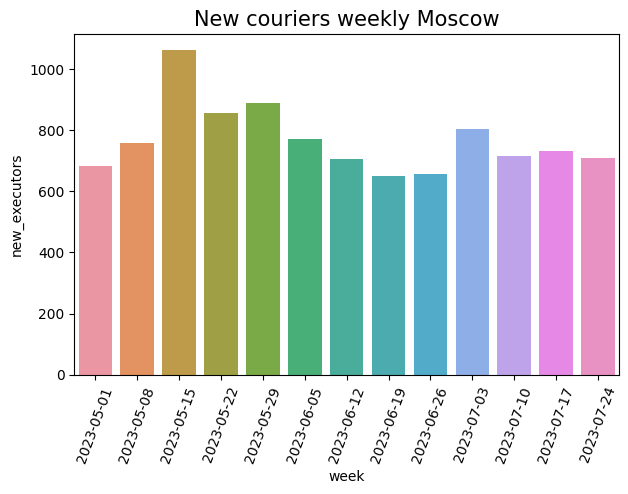

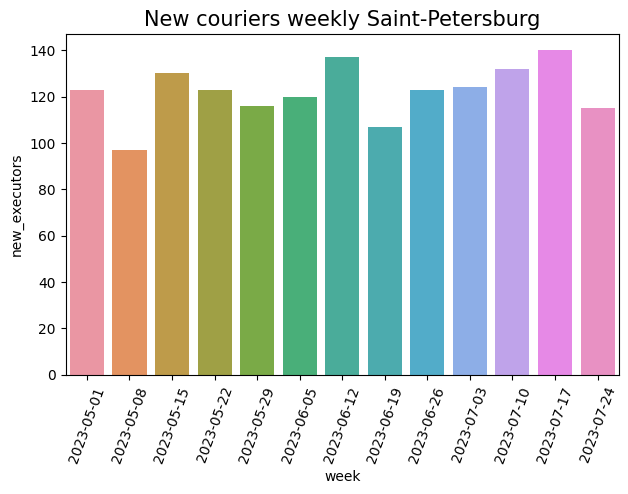

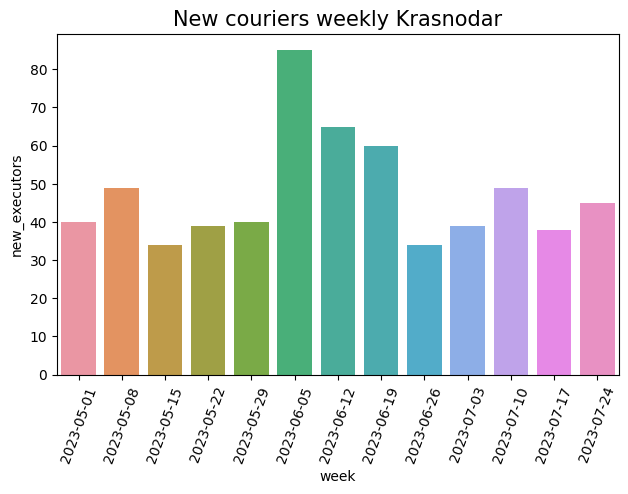

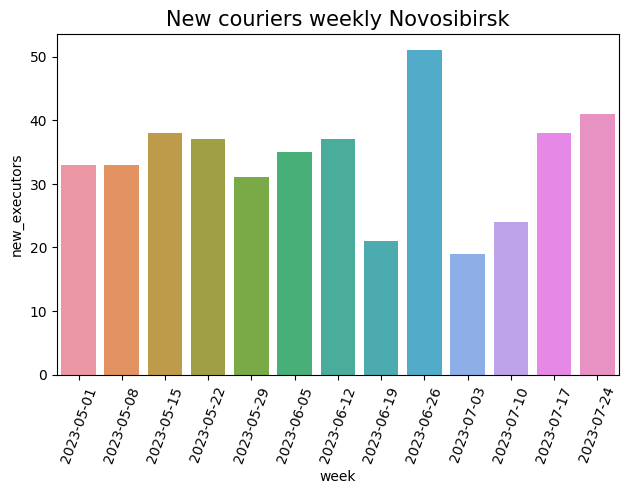

In [28]:
for node in regions['cities']:
    df_i = newbies_df[newbies_df['source_city_name_en']==node]
    
    ax = sns.barplot(data=df_i, x="week", y="new_executors")
    plt.xticks(rotation=70)
    plt.tight_layout()

    ax.set_title(f'''New couriers weekly {node}''', fontsize=15)
    plt.show()

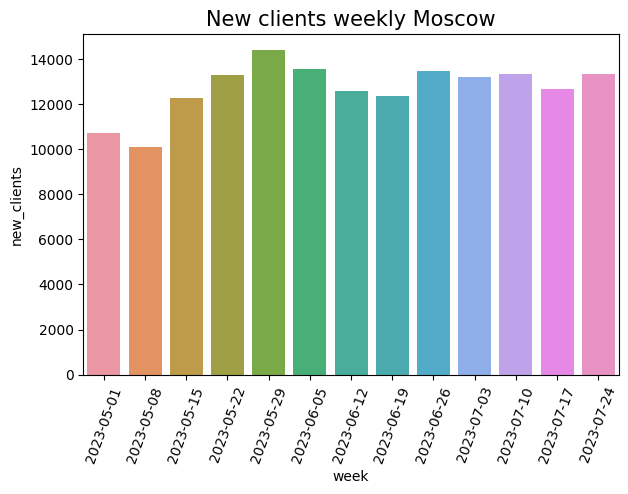

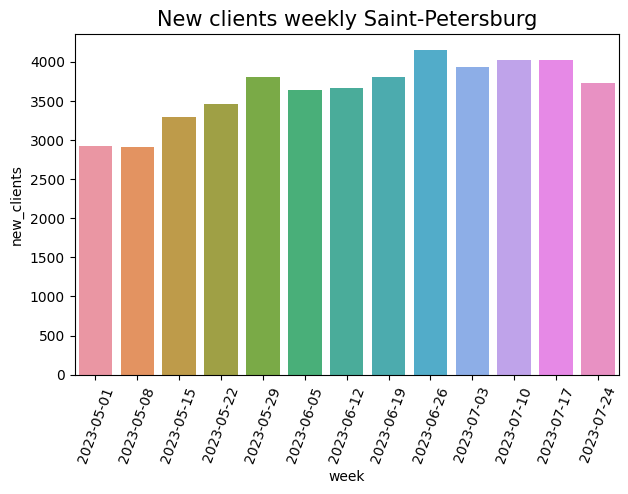

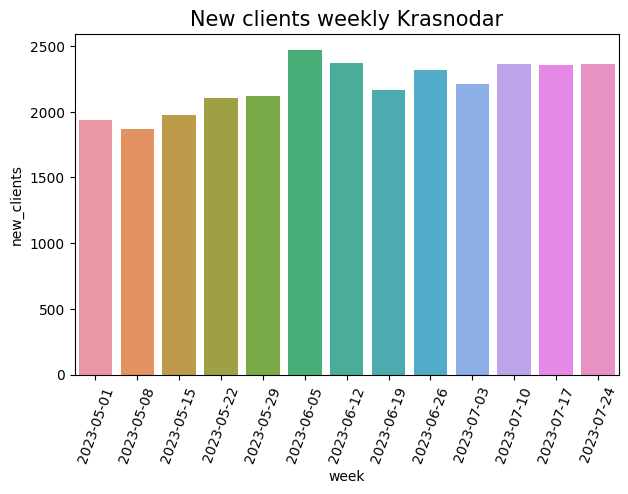

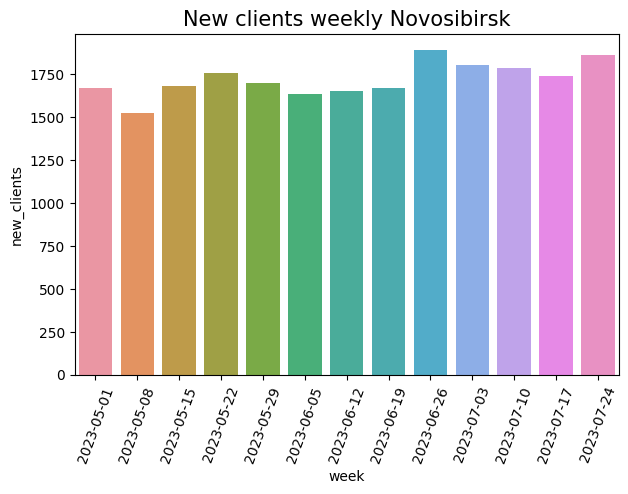

In [29]:
for node in regions['cities']:
    df_i = newbies_df[newbies_df['source_city_name_en']==node]
    
    ax = sns.barplot(data=df_i, x="week", y="new_clients")
    plt.xticks(rotation=70)
    plt.tight_layout()

    ax.set_title(f'''New clients weekly {node}''', fontsize=15)
    plt.show()